In [1]:
import datasets
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from transformers import AutoModel, AutoTokenizer

from sae.data import chunk_and_tokenize

%load_ext autoreload
%autoreload 2

In [2]:
torch.manual_seed(42)

In [3]:
dataset = datasets.load_dataset(
    "togethercomputer/RedPajama-Data-1T-Sample", split="train[:1000]"
)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
dataset = chunk_and_tokenize(dataset, tokenizer, max_seq_len=32)
model = AutoModel.from_pretrained("gpt2", device_map={"": 0})

In [4]:
model.config.num_hidden_layers

12

In [51]:
@torch.no_grad()
def per_token_pca(
    model, sample_input_ids: torch.Tensor, token_idx: int, pca_n_components: int = 16
):
    if sample_input_ids.dim() == 1:
        sample_input_ids = sample_input_ids.unsqueeze(0)
    input_ids = sample_input_ids[:, token_idx].unsqueeze(0)
    hidden_states = model(input_ids, output_hidden_states=True).hidden_states[1:]
    # reshape to (S, H * L)
    hidden_states = (
        torch.cat(hidden_states, dim=1)
        .squeeze()
        .reshape(-1, len(hidden_states) * model.config.hidden_size)
    )
    pca = PCA(n_components=pca_n_components)
    pca.fit(hidden_states.cpu().numpy())
    # scree plot
    # Calculate cumulative explained variance ratio
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

    # Create scree plot
    plt.figure(figsize=(10, 6))
    plt.plot(
        range(1, len(pca.explained_variance_ratio_) + 1),
        cumulative_variance_ratio,
        "bo-",
    )
    plt.plot(
        range(1, len(pca.explained_variance_ratio_) + 1),
        pca.explained_variance_ratio_,
        "ro-",
    )
    plt.xlabel("Number of Components")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Scree Plot")
    plt.legend(
        ["Cumulative Explained Variance Ratio", "Individual Explained Variance Ratio"]
    )

    # Add a line at 95% cumulative explained variance
    plt.axhline(y=0.95, color="g", linestyle="--")
    plt.text(1, 0.96, "95% Cut-off", color="g", va="center", ha="left")

    plt.tight_layout()
    plt.show()


@torch.no_grad()
def per_token_cov(model, sample_input_ids: torch.Tensor, token_idx: int):
    # Compute the covariance matrix
    input_ids = sample_input_ids[:, token_idx].unsqueeze(0)
    hidden_states = model(input_ids, output_hidden_states=True).hidden_states[1:]
    # reshape to (S, H * L)
    hidden_states = (
        torch.cat(hidden_states, dim=1)
        .squeeze()
        .reshape(-1, len(hidden_states) * model.config.hidden_size)
    )
    cov_matrix = torch.cov(hidden_states)

    # Compute eigenvalues
    eigenvalues, _ = torch.linalg.eig(cov_matrix)
    eigenvalues = eigenvalues.real  # Extract real part of eigenvalues
    eigenvalues, _ = torch.sort(eigenvalues, descending=True)

    # Convert to numpy for plotting
    eigenvalues_np = eigenvalues.cpu().numpy()

    # Create scree plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(eigenvalues_np) + 1), eigenvalues_np, "bo-")
    plt.xlabel("Principal Component")
    plt.ylabel("Eigenvalue")
    plt.title("Scree Plot")
    plt.grid(True)

    # Add cumulative explained variance
    cumulative_variance = torch.cumsum(eigenvalues, dim=0) / torch.sum(eigenvalues)
    cumulative_variance_np = cumulative_variance.cpu().numpy()

    plt.twinx()
    plt.plot(
        range(1, len(cumulative_variance_np) + 1), cumulative_variance_np * 100, "r--"
    )
    plt.ylabel("Cumulative Explained Variance (%)")

    plt.show()

    # Print some statistics
    print(f"Total number of components: {len(eigenvalues_np)}")
    print(f"Sum of all eigenvalues: {eigenvalues_np.sum():.4f}")
    print(
        f"Explained variance by top {min(10, len(eigenvalues_np))} components: {cumulative_variance_np[min(9, len(eigenvalues_np))-1]*100:.2f}%"
    )

In [57]:
n_samples = 1024
sample_data = dataset.select(range(n_samples))["input_ids"].cuda()

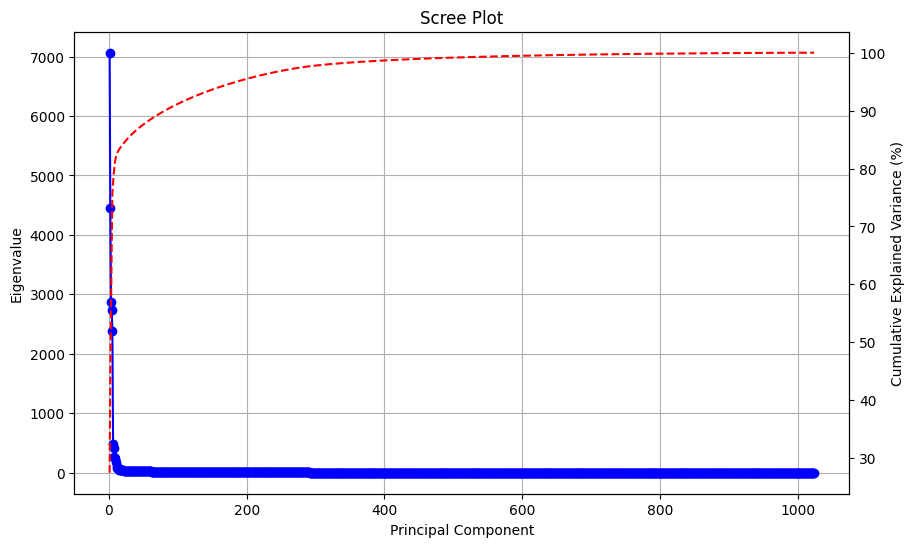

Total number of components: 1024
Sum of all eigenvalues: 25728.4395
Explained variance by top 10 components: 81.26%


In [58]:
per_token_cov(model, sample_data, -1)

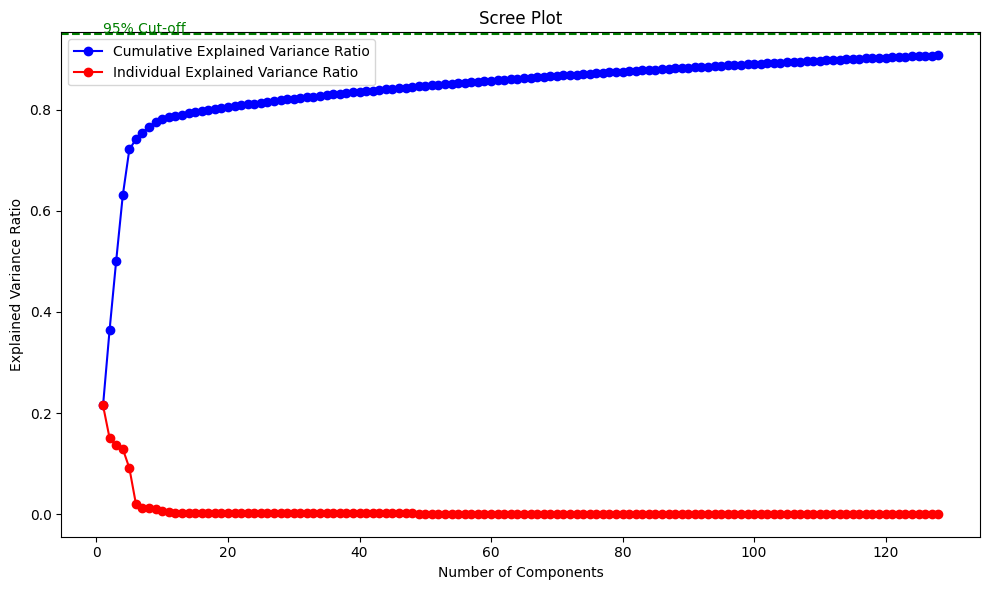

In [60]:
per_token_pca(model, sample_data, -1, pca_n_components=128)